## Семинар 2 "Распознавание рукописных цифр"

ФИО: Жолковский Евгений Константинович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [44]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline
import torchsample as ts
import time

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [6]:
X, y = next(iter(train_loader))

In [4]:
# функция augm немного искажает и поворачивает изображения

def augm(X, angle_range=20, shear_range=10):

    for i in range(X.shape[0]):
        angle = (np.random.rand(1)[0]-0.5)*angle_range*2
        shear = (np.random.rand(1)[0]-0.5)*shear_range*2

        a1 = ts.transforms.Rotate(angle)(X[i])
        X[i] = ts.transforms.Shear(shear)(a1)
    return X

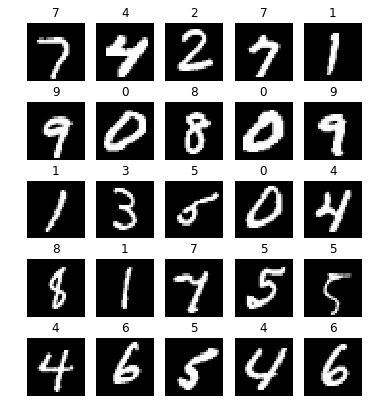

In [8]:
X_ = X.numpy()
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

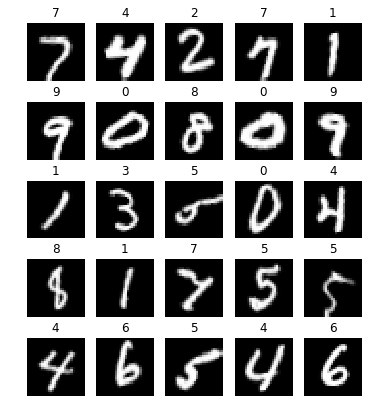

In [9]:
X__ = augm(X).numpy()
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X__[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [13]:
def train(network, epochs, learning_rate, aug=False):
    loss = NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            
            for X, y in train_loader:
                if aug:
                    X = augm(X).view(X.shape[0], -1).numpy()
                else:
                    X = X.view(X.shape[0], -1).numpy()
                
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.5f}/{4:.5f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    
    except KeyboardInterrupt:
        pass
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

## Sigmoid

In [11]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 49... (Train/Test) NLL: 0.101/0.128	Accuracy: 0.973/0.965

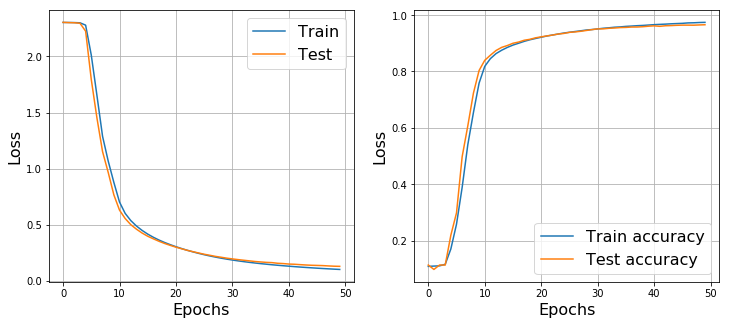

In [12]:
train(network, 50, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [7]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.relu = np.maximum(X,0)
        return self.relu
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.relu>0)*dLdy
    
    def step(self, learning_rate):
        pass

In [8]:
class ELU:
    def __init__(self, alpha):
        self.a = alpha
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.elu = (X>0)*X + (X<=0)*self.a*(np.exp(X) - 1)
        return self.elu
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return ((self.elu<=0)*(self.elu +self.a) + (self.elu >0)*1 )*dLdy
    
    def step(self, learning_rate):
        pass

## ReLU

In [15]:
network0 = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 49... (Train/Test) NLL: 0.003/0.098	Accuracy: 1.000/0.977

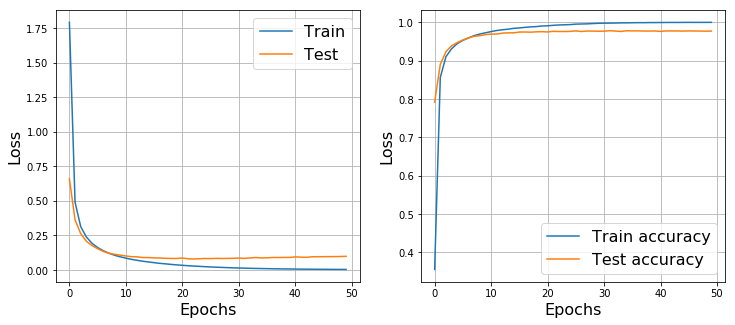

In [16]:
train(network0, 50, 0.01)

## ELU

In [17]:
network1 = NeuralNetwork([Linear(784, 100), ELU(1),
               Linear(100, 100), ELU(1),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 49... (Train/Test) NLL: 0.005/0.081	Accuracy: 1.000/0.979

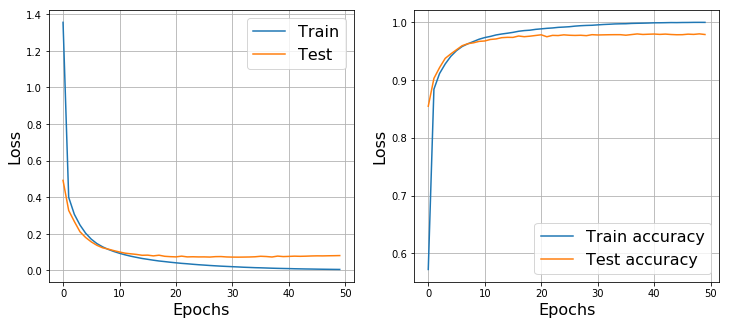

In [18]:
train(network1, 50, 0.01)

## ELU + augmentation

In [27]:
network2 = NeuralNetwork([Linear(784, 100), ELU(1),
               Linear(100, 100), ELU(1),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 49... (Train/Test) NLL: 0.053/0.056	Accuracy: 0.98370/0.98313

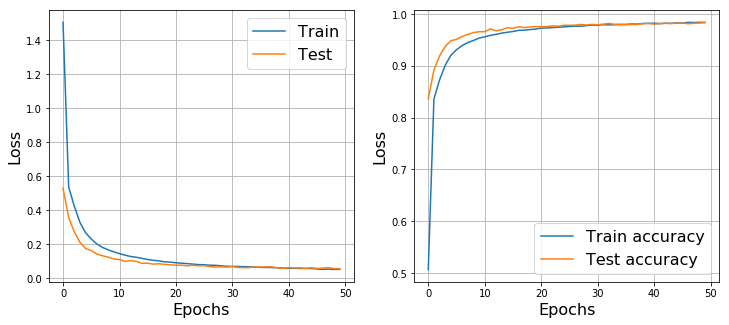

In [28]:
train(network2, 50, 0.01, aug=True)

Epoch 49... (Train/Test) NLL: 0.034/0.054	Accuracy: 0.98947/0.98413

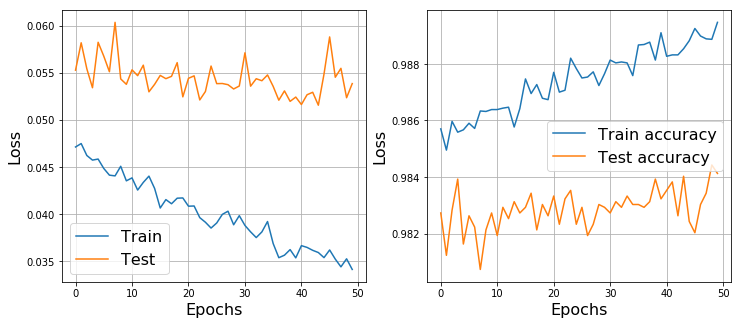

In [29]:
train(network2, 50, 0.005, aug=True)

Epoch 49... (Train/Test) NLL: 0.029/0.052	Accuracy: 0.99110/0.98462

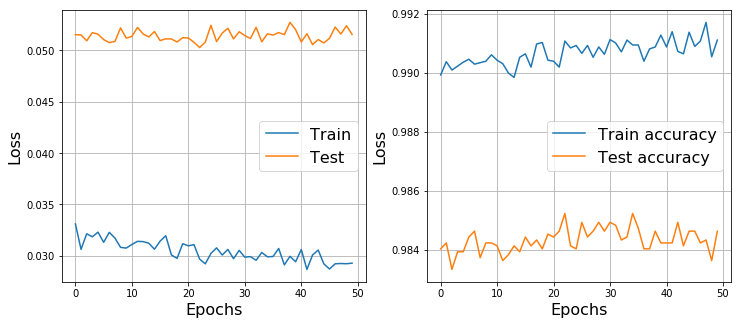

In [30]:
train(network2, 50, 0.001, aug=True)

## 200

In [32]:
network3 = NeuralNetwork([Linear(784, 200), ELU(1),
               Linear(200, 200), ELU(1),
               Linear(200, 10)])
loss = NLLLoss()

In [ ]:
train(network3, 100, 0.01, aug=True)

Epoch 1... (Train/Test) NLL: 0.487/0.325	Accuracy: 0.85470/0.90405

In [ ]:
train(network3, 100, 0.005, aug=True)

In [ ]:
train(network3, 100, 0.001, aug=True)

In [ ]:
train(network3, 40, 0.001, aug=True)

Epoch 17... (Train/Test) NLL: 0.008/0.055	Accuracy: 0.99785/0.98502

Я считал на сервере с закрытым jupyter, графики не отобразились

### Часть 3: Анализ ошибок

In [42]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network3.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            #predicted_y.append(prediction.argmax(1))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

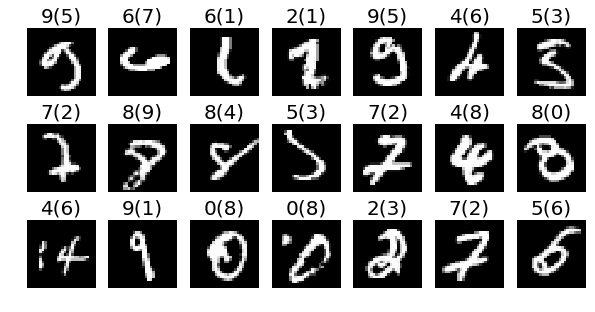

In [43]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Расчет с архитектурой 784-100-100-10 и тремя типами нелинейности дает разный результат. На для ELU и ReLU сходится быстрее. На тестовой выборке с Sigma() достигается точность 0.965. На ReLU() - 0.977, на ELU(1) - 0.984. С архитектурой 784-200-200-10 полученный результат - 0.985. В процессе обучения достигался резкльтат 0.986 на тестовой выборке. Сходимость для градиентного спуска с фиксированным learning_rate очень медленная.